## Train models

In [ ]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pickle

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest_alt', default='../trained_models/dgcca_toy_altmaxvar2.model', help="Destination model path")
parser.add_argument('--model_dest_cute', default='../trained_models/dgcca_toy_cutemaxvar2.model', help="Destination model path")

parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=False, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=1000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=10, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=50, help='')
parser.add_argument('--n_trials', default=2, help='')

args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0

device = torch.device(args['device'])

acc = {'alt':np.zeros((args['n_trials'], args['num_epochs'])),
      'cute':np.zeros((args['n_trials'], args['num_epochs']))}

compress_exps = [True, False]

# acc_alt = np.zeros((args['n_trials'], args['num_epochs']))
# acc = pickle.load(open('../plt/acc_cute_toy.pkl', 'rb'))
for compress in compress_exps:
    args['compress'] = compress
    if compress:
        args['model_dest'] = args['model_dest_cute']
    else:
        args['model_dest'] = args['model_dest_alt']
    for trial_id in range(args['n_trials']):
        run_data = []

        # eval and train models and copy the train params to eval
        dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca_train = dgcca_train.to(device)
        dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
        dgcca_eval.load_state_dict(dgcca_train.state_dict())

        # Get train and validation dataset
        train_views, train_classes = create_synthData(N=10000)
        val_views, val_classes = create_synthData(N=2000)
        # shuffle the dataset
        suffler = torch.randperm(10000)
        train_views = [view[suffler].to(device) for view in train_views]

        val_shuffler = torch.randperm(2000)
        val_views = [view[val_shuffler].to(device) for view in val_views]
        val_classes = [classes[val_shuffler] for classes in val_classes]

        optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
        num_batches = len(train_views[0])//args['batch_size']

        criterion = loss_func()
        num_val_batches = len(val_views[0])//args['batch_size']

        # init G
        dgcca_eval.eval()
        M_client = torch.stack(dgcca_eval(train_views))
        G_server = g_step(M_client.clone().detach())  

        M_serv = M_client.clone()
        G_client = G_server.clone()

        dgcca_train.train()

        for epoch in range(args['num_epochs']):
            total_dgcca_loss = 0
            total_val_loss = 0
            batch_count = 0

            for j in range(args['inner_epochs']):
                for i in range(num_batches):
                    optimizer.zero_grad()
                    batch = []

                    # SGD

                    batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
                    target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

                    # full gradient
                    # batch = train_views
                    # target = G

                    out = torch.stack(dgcca_train(batch))  

                    loss = 1/2*torch.norm(out-target)/target.shape[0]

                    loss.backward()
                    optimizer.step()

                    total_dgcca_loss += loss.item()

            ## Update G
            dgcca_eval.load_state_dict(dgcca_train.state_dict())
            M_client = dgcca_eval(train_views)
            M_client = torch.stack(M_client)

            if args['compress']:
                for i in range(len(train_views)):
                    diff = M_client[i] - M_serv[i]
                    max_val = diff.abs().max()
                    if args['compression_scheme'] == 'qsgd':
                        quant = qsgd(diff, n_bits=args['nbits'])
                    else:
                        quant = ((1/max_val)*diff).round()*(max_val/1)    
                    M_serv[i] = M_serv[i] + quant
                    M_serv[i] -= M_serv[i].mean(dim=0)
                    del max_val, diff, quant
                    G_serv = g_step(M_serv.clone().detach())

                if args['compress_downlink']:
                    if args['compression_scheme'] == 'qsgd':
                        G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
                    else:
                        # TODO: implement compression inside functions
                        G_client = G_serv.clone()
                else:
                    G_client = G_serv.clone()
            else:
                M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
                M_serv = M_client.clone()
                G_serv = g_step(M_serv.clone().detach())  
                G_client = G_serv.clone() 
            del M_client

            # validation loss
            out_val = torch.stack(dgcca_eval(val_views))
            G_val = g_step(out_val.clone().detach())
            loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
            total_val_loss = loss_val.item()

            clf = svm.LinearSVC()
            clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

            results = OrderedDict()
            results['epoch'] = epoch
            results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
            results['val_fidelity'] = total_val_loss
            results['batch_size'] = args['batch_size']
            results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
            results['lr'] = args['lr']
            results['device'] = args['device']

            if args['compress']:
                acc['cute'][trial_id, epoch] = results['class_acc']
            else:
                acc['alt'][trial_id, epoch] = results['class_acc']

            run_data.append(results)
            df_cute = pd.DataFrame.from_dict(run_data, orient='columns')
            clear_output(wait=True)
            display(df_cute)

            torch.save(dgcca_train, args['model_dest'])

,epoch,data_fidelity,val_fidelity,batch_size,class_acc,lr,device
0,0,0.001654,0.000478,1000,0.740,0.001,cpu
1,1,0.000474,0.000494,1000,0.719,0.001,cpu
2,2,0.000435,0.000488,1000,0.718,0.001,cpu
3,3,0.000412,0.000498,1000,0.707,0.001,cpu
4,4,0.000435,0.000508,1000,0.689,0.001,cpu
5,5,0.000399,0.000497,1000,0.744,0.001,cpu
6,6,0.000382,0.000493,1000,0.786,0.001,cpu
7,7,0.000366,0.000486,1000,0.847,0.001,cpu
8,8,0.000353,0.000481,1000,0.899,0.001,cpu
9,9,0.000343,0.000479,1000,0.923,0.001,cpu


In [3]:
import pickle
# acc = {'cute': acc_cute}
with open('../plt/acc_cute_toy.pkl', 'wb') as f:
    pickle.dump(acc, f)
    


In [11]:
from collections import OrderedDict, namedtuple
from itertools import product
import argparse
from tqdm import tqdm, trange
from IPython.display import clear_output
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from dgcca.utils.run_manager import RunBuilder
from dgcca.utils.compressor import qsgd
from dgcca.models import g_step, DeepGCCA
from dgcca.toy_2d.synth_data_toy_2d import create_synthData
import pprint as pp
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

parser = argparse.ArgumentParser(description="Toy 2d DGCCA")

# Data
parser.add_argument('--model_dest', default='../trained_models/dgcca_toy_cutemaxvar1.model', help="Destination model path")
parser.add_argument('--random_seed', default=5555, help='')
parser.add_argument('--compress', default=True, help='')
parser.add_argument('--compression_scheme', default='qsgd', help='')
parser.add_argument('--compress_downlink', default=True, help='')
parser.add_argument('--batch_size', default=1000, help='')
parser.add_argument('--lr', default=0.001, help='')
parser.add_argument('--device', default='cpu', help='')
parser.add_argument('--inner_epochs', default=10, help='')
parser.add_argument('--shuffle', default=True, help='')
parser.add_argument('--nbits', default=3, help='')
parser.add_argument('--num_epochs', default=0, help='')

args = vars(parser.parse_args([]))
pp.pprint(args)

# Set the random seed
torch.manual_seed(int(args['random_seed']))

# some special parameters
layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]
num_workers = 5
loss_func = nn.MSELoss

data_load_time = 0
forward_time = 0
run_data = []

device = torch.device(args['device'])

# eval and train models and copy the train params to eval
dgcca_train = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_train = dgcca_train.to(device)
dgcca_eval = DeepGCCA(layer_sizes_list, input_size_list)
dgcca_eval.load_state_dict(dgcca_train.state_dict())

# Get train and validation dataset
train_views, train_classes = create_synthData(N=10000)
val_views, val_classes = create_synthData(N=2000)
# shuffle the dataset
suffler = torch.randperm(10000)
train_views = [view[suffler].to(device) for view in train_views]

val_shuffler = torch.randperm(2000)
val_views = [view[val_shuffler].to(device) for view in val_views]
val_classes = [classes[val_shuffler] for classes in val_classes]

optimizer = torch.optim.Adam(dgcca_train.parameters(), lr=args['lr'])
num_batches = len(train_views[0])//args['batch_size']

criterion = loss_func()
num_val_batches = len(val_views[0])//args['batch_size']

# init G
dgcca_eval.eval()
M_client = torch.stack(dgcca_eval(train_views))
G_server = g_step(M_client.clone().detach())  

M_serv = M_client.clone()
G_client = G_server.clone()

dgcca_train.train()

for epoch in range(args['num_epochs']):
    total_dgcca_loss = 0
    total_val_loss = 0
    batch_count = 0

    for j in range(args['inner_epochs']):
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*args['batch_size']):((i+1)*args['batch_size']), :] for view in train_views]            
            target = G_client[(i*args['batch_size']):((i+1)*args['batch_size']), :]

            # full gradient
            # batch = train_views
            # target = G

            out = torch.stack(dgcca_train(batch))  

            loss = 1/2*torch.norm(out-target)/target.shape[0]

            loss.backward()
            optimizer.step()

            total_dgcca_loss += loss.item()

    ## Update G
    dgcca_eval.load_state_dict(dgcca_train.state_dict())
    M_client = dgcca_eval(train_views)
    M_client = torch.stack(M_client)

    if args['compress']:
        for i in range(len(train_views)):
            diff = M_client[i] - M_serv[i]
            max_val = diff.abs().max()
            if args['compression_scheme'] == 'qsgd':
                quant = qsgd(diff, n_bits=args['nbits'])
            else:
                quant = ((1/max_val)*diff).round()*(max_val/1)    
            M_serv[i] = M_serv[i] + quant
            M_serv[i] -= M_serv[i].mean(dim=0)
            del max_val, diff, quant
            G_serv = g_step(M_serv.clone().detach())
        
        if args['compress_downlink']:
            if args['compression_scheme'] == 'qsgd':
                G_client = G_client + qsgd(G_serv-G_client, n_bits=args['nbits'])
            else:
                # TODO: implement compression inside functions
                G_client = G_serv.clone()
        else:
            G_client = G_serv.clone()
    else:
        M_client = M_client - M_client.mean(dim=1).unsqueeze(dim=1)
        M_serv = M_client.clone()
        G_serv = g_step(M_serv.clone().detach())  
        G_client = G_serv.clone() 
    del M_client

    # validation loss
    out_val = torch.stack(dgcca_eval(val_views))
    G_val = g_step(out_val.clone().detach())
    loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
    total_val_loss = loss_val.item()

    clf = svm.LinearSVC()
    clf.fit(G_val[:-1000,:].numpy(), val_classes[0][:-1000].numpy())

    results = OrderedDict()
    results['epoch'] = epoch
    results['data_fidelity'] = total_dgcca_loss/(num_batches*args['inner_epochs'])
    results['val_fidelity'] = total_val_loss
    results['batch_size'] = args['batch_size']
    results['class_acc'] = accuracy_score(val_classes[0][-1000:].numpy(), clf.predict(G_val[-1000:,:]))
    results['lr'] = args['lr']
    results['device'] = args['device']
    
    run_data.append(results)
    df_cute_full = pd.DataFrame.from_dict(run_data, orient='columns')
    clear_output(wait=True)
    display(df_cute_full)

    torch.save(dgcca_train, args['model_dest'])

{'batch_size': 1000,
 'compress': True,
 'compress_downlink': True,
 'compression_scheme': 'qsgd',
 'device': 'cpu',
 'inner_epochs': 10,
 'lr': 0.001,
 'model_dest': '../trained_models/dgcca_toy_cutemaxvar1.model',
 'nbits': 3,
 'num_epochs': 0,
 'random_seed': 5555,
 'shuffle': True}


In [15]:
acc['cute']

array([[0.632, 0.59 , 0.525, 0.558, 0.542, 0.586, 0.616, 0.622, 0.712,
        0.773, 0.839, 0.887, 0.873, 0.844, 0.842, 0.853, 0.771, 0.695,
        0.742, 0.795, 0.855, 0.861, 0.775, 0.807, 0.811, 0.864, 0.931,
        0.93 , 0.932, 0.956, 0.958, 0.977, 0.968, 0.929, 0.918, 0.927,
        0.926, 0.918, 0.88 , 0.903, 0.944, 0.947, 0.942, 0.943, 0.943,
        0.931, 0.924, 0.941, 0.943, 0.942],
       [0.599, 0.606, 0.603, 0.617, 0.641, 0.684, 0.71 , 0.81 , 0.879,
        0.887, 0.9  , 0.942, 0.97 , 0.974, 0.959, 0.959, 0.92 , 0.942,
        0.942, 0.961, 0.936, 0.968, 0.96 , 0.941, 0.932, 0.926, 0.926,
        0.948, 0.964, 0.973, 0.959, 0.932, 0.929, 0.935, 0.954, 0.951,
        0.933, 0.978, 0.985, 0.992, 0.952, 0.954, 0.975, 0.973, 0.976,
        0.982, 0.982, 0.992, 0.992, 0.963],
       [0.534, 0.639, 0.608, 0.539, 0.52 , 0.461, 0.477, 0.532, 0.528,
        0.643, 0.777, 0.906, 0.931, 0.947, 0.967, 0.966, 0.971, 0.95 ,
        0.93 , 0.928, 0.935, 0.911, 0.927, 0.964, 0.982, 0.9

In [16]:
acc['alt']

array([[0.642, 0.582, 0.601, 0.596, 0.56 , 0.663, 0.669, 0.775, 0.848,
        0.908, 0.941, 0.885, 0.871, 0.906, 0.914, 0.926, 0.907, 0.952,
        0.941, 0.926, 0.972, 0.946, 0.908, 0.885, 0.911, 0.93 , 0.946,
        0.962, 0.955, 0.954, 0.907, 0.943, 0.95 , 0.962, 0.979, 0.948,
        0.956, 0.965, 0.973, 0.982, 0.99 , 0.981, 0.972, 0.973, 0.953,
        0.957, 0.971, 0.978, 0.94 , 0.944],
       [0.626, 0.652, 0.704, 0.68 , 0.714, 0.756, 0.781, 0.814, 0.898,
        0.923, 0.947, 0.94 , 0.941, 0.964, 0.963, 0.964, 0.976, 0.967,
        0.974, 0.959, 0.961, 0.945, 0.974, 0.985, 0.969, 0.963, 0.955,
        0.955, 0.962, 0.965, 0.967, 0.973, 0.982, 0.99 , 0.974, 0.968,
        0.974, 0.992, 0.994, 0.994, 0.994, 0.996, 0.993, 0.988, 0.968,
        0.968, 0.975, 0.983, 0.987, 0.984],
       [0.6  , 0.627, 0.676, 0.715, 0.795, 0.856, 0.882, 0.89 , 0.893,
        0.896, 0.917, 0.932, 0.944, 0.941, 0.95 , 0.952, 0.96 , 0.948,
        0.939, 0.937, 0.93 , 0.928, 0.933, 0.948, 0.947, 0.9

In [1]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

comm_cute = np.arange(50)*3 + 32
comm_alt = np.arange(50)*32 + 32

cute_mean = acc['cute'].mean(axis=0)
alt_mean = acc['alt'].mean(axis=0)
cute_std = acc['cute'].std(axis=0)
alt_std = acc['alt'].std(axis=0)


axes[0].plot(comm_cute, acc['cute'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_cute, cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[0].plot(comm_alt, acc['alt'].mean(axis=0), linewidth=2)
axes[0].fill_between(comm_alt, alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[0].legend(['CuteMaxVar-Deep', 'AltMaxVar-Deep'], fontsize=14)
axes[0].set_xlabel('communication cost (BPV)', fontsize=14)
axes[0].set_ylabel('Classification accuracy', fontsize=14)
axes[0].set_xlim(0, 1000)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)


axes[1].plot(acc['cute'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(cute_mean)), cute_mean+cute_std, cute_mean-cute_std, alpha=0.2)
axes[1].plot(acc['alt'].mean(axis=0), linewidth=2)
axes[1].fill_between(np.arange(len(alt_mean)), alt_mean+alt_std, alt_mean-alt_std, alpha=0.2)

axes[1].set_xlabel('iteration', fontsize=14)
axes[1].set_ylabel('Classification accuracy', fontsize=14)

axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)


NameError: name 'plt' is not defined

In [12]:
fig.savefig('../plt/toy_class_acc.pdf')

In [46]:


# classification for distributed method
clf_dist = svm.LinearSVC()
clf_dist.fit(G_val[:-200,:].numpy(), val_classes[0][:-200].numpy())

accuracy_score(val_classes[0][:-200].numpy(), clf_dist.predict(G_val[:-200,:]))


LinearSVC()

In [44]:
G_val.shape

torch.Size([1000, 2])

## Plots mini batch GD

In [9]:
from dgcca.utils.clustering import *

dgcca_vanilla = torch.load('../trained_models/dgcca_toy_altmaxvar.model')
dgcca_dist = torch.load('../trained_models/dgcca_toy_cutemaxvar.model')

test_views, classes = create_synthData(N=1000)
test_views = [view.to(device) for view in test_views]


acc_raw = []

for view in test_views:
    acc_raw.append(get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=view, test_classes=classes[0]))

out1 = dgcca_vanilla(test_views)
out1 = [a.to('cpu').detach() for a in out1]


out1 = dgcca_vanilla(test_views)
G_vanilla = g_step(torch.stack(out1).clone().detach())
out1 = [a.to('cpu').detach() for a in out1]

out2 = dgcca_dist(test_views)
G_dist = g_step(torch.stack(out2).clone().detach())
out2 = [a.to('cpu').detach() for a in out2]

G_vanilla = G_vanilla.detach().to('cpu')
vanilla_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_vanilla, test_classes=classes[0])

G_dist = G_dist.detach().to('cpu')
dist_cluster_acc = get_clustering_acc(n_clusters=2, gamma=5, random_state=100, latent_repr=G_dist, test_classes=classes[0])

target = [t.to('cpu').detach() for t in test_views]



TypeError: can't convert cuda:2 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

IndexError: too many indices for tensor of dimension 1

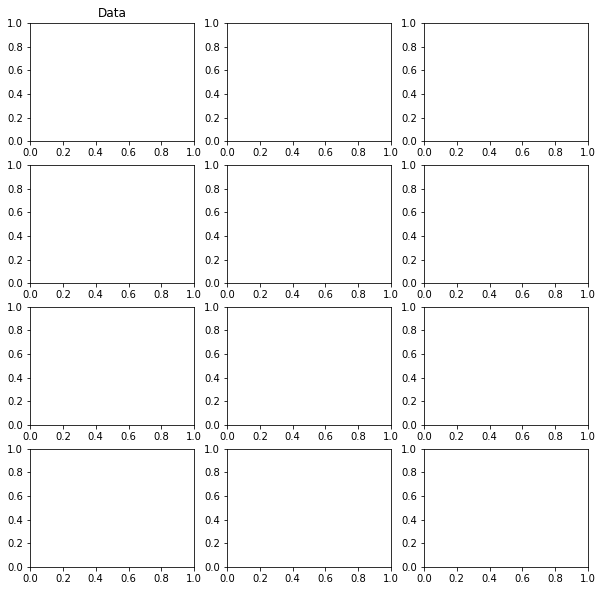

In [8]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

axes[0,0].set_title('Data')
axes[0,0].scatter(target[0][:,0], target[0][:,1], c=500*[1]+500*[2])
axes[0,0].set_ylabel('View1')
axes[0,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[0]*100)) +" %")

axes[1,0].scatter(target[1][:,0], target[1][:,1], c=500*[1]+500*[2])
axes[1,0].set_ylabel('View2')
axes[1,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[1]*100)) +" %")

axes[2,0].scatter(target[2][:,0], target[2][:,1], c=500*[1]+500*[2])
axes[2,0].set_ylabel('View3')
axes[2,0].set_xlabel("Clust. Acc. " + str(int(acc_raw[2]*100)) +" %")


axes[0,1].set_title("AltMaxVar-Deep")
axes[0,1].scatter(out1[0][:,0], out1[0][:,1], c=500*[1]+500*[2])
axes[1,1].scatter(out1[1][:,0], out1[1][:,1], c=500*[1]+500*[2])
axes[2,1].scatter(out1[2][:,0], out1[2][:,1], c=500*[1]+500*[2])
axes[3,1].set_xlabel("Clust. Acc. " + str(int(vanilla_cluster_acc*100)) +" %")
axes[3,1].set_title('Latent Representation ' + r'${\mathbf{G}}$')
axes[3,1].scatter(G_vanilla[:,0], G_vanilla[:,1], c=500*[1]+500*[2])

axes[0,2].set_title("CuteMaxVar-Deep")
axes[0,2].scatter(out2[0][:,0], out2[0][:,1], c=500*[1]+500*[2])
axes[1,2].scatter(out2[1][:,0], out2[1][:,1], c=500*[1]+500*[2])
axes[2,2].scatter(out2[2][:,0], out2[2][:,1], c=500*[1]+500*[2])
axes[3,2].set_xlabel("Clust. Acc. " + str(int(dist_cluster_acc*100)) +" %")
axes[3,2].set_title('Latent Representation ' + r'$\widehat{\mathbf{G}}$')

axes[3,2].scatter(G_dist[:,0], G_dist[:,1], c=500*[1]+500*[2])

axes[3,0].axis('off')
for i in range(4):
    for j in range(3):
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


In [73]:
fig.savefig('../plt/toy_scatter_plot.pdf')

## Classification error

In [100]:
vanilla = torch.load('trained_models/dgcca_sgd_classifier.model')
fed = torch.load('trained_models/dgcca_fed_sgd_classifier.model')

train_views, train_classes = create_synthData(N=1000)

train_views = [view.to(device) for view in train_views]

# out1 = dgcca_vanilla(train_views)

out1 = dgcca_vanilla(train_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.type(torch.float32).detach() for a in out1]

out2 = dgcca_fed(train_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.type(torch.float32).detach() for a in out2]

vanilla_class = []
for i in range(3):
    a = vanilla.model_list[i](out1[i])
    vanilla_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = vanilla.model_list[3](G1.type(torch.float32))
vanilla_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())


fed_class = []
for i in range(3):
    a = fed.model_list[i](out2[i])
    fed_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = fed.model_list[3](G2.type(torch.float32))
fed_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())